
# ASR and KWS with Wav2Vec2


### Overview
Wav2Vec2 (and HuBERT) models are trained in self-supervised manner. They are firstly trained with audio only for representation learning, then fine-tuned for a specific task with additional labels.
The process of speech recognition looks like the following.

1. Extract the acoustic features from audio waveform

2. Estimate the class of the acoustic features frame-by-frame

3. Generate hypothesis from the sequence of the class probabilities

In [1]:
import os
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
import numpy as np
import Levenshtein as lvsim
import IPython.display as ipd

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)

# uncomment this for device other than M1/M2 Mac
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.0.0.dev20230123
2.0.0.dev20230123
cpu


#### Run pytorch on M1 GPU

In [2]:
"""
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())


# To run PyTorch code on the GPU, use torch.device("mps") analogous to torch.device("cuda") on an Nvidia GPU.
dtype = torch.float
device = torch.device("mps")
print(device)
"""


'\n# this ensures that the current MacOS version is at least 12.3+\nprint(torch.backends.mps.is_available())\n# this ensures that the current current PyTorch installation was built with MPS activated.\nprint(torch.backends.mps.is_built())\n\n\n# To run PyTorch code on the GPU, use torch.device("mps") analogous to torch.device("cuda") on an Nvidia GPU.\ndtype = torch.float\ndevice = torch.device("mps")\nprint(device)\n'

### Helper functions and model functions

In [3]:

class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])
    
class wav2vec2Model:
    def __init__(self):
        # loading the pretrained and fine-tuned wav2vec2 model for speech recognition
        self.bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
        self.model_fs = self.bundle.sample_rate
        
    
    def get_model_detail(self):
        return self.bundle.sample_rate, self.bundle.get_labels()
    
    def load_singlefile (self, speech_file):
        wav, fs = torchaudio.load(speech_file)
        wav = wav.to(device)
        return wav,fs
        
    def resample(self, wav, fs):
        if fs != self.model_fs:
            wav = torchaudio.functional.resample(wav, fs, self.model_fs)
        return wav
    
    def get_asr_model (self,device):
        self.model = self.bundle.get_model().to(device)
        print(self.model.__class__)
        return self.model
    
    def get_layer_features(self,wav):
        with torch.inference_mode():
            feats, _ = self.model.extract_features(wav)
            return feats
    
    def feat_classification (self,wav):
        with torch.inference_mode():
            emission, _ = model(wav)
            decoder = GreedyCTCDecoder(labels=self.bundle.get_labels())
            transcript = decoder(emission[0])
        return transcript
    
            
def analyze_asr_transcript (trasncript, target_word):
    trasncript = trasncript.lower()
    keywords = trasncript.split('|')
    eq_flg = target_word.lower()== keywords[1] # check custom word
    
    target_keyword_detected = False
    if len(keywords) == 3: # 'hey' + custom word + pause('')
        if eq_flg and (keywords[0] == 'a' or keywords[0] == 'hey') and keywords[2] == '': # checking 'hey'+ target word
                target_keyword_detected = True
    
    return keywords,target_keyword_detected


def analyze_uniqueness_ask (keywords,common_words):
    # uniqueness score based on computing string edit distances and similarities.

    ww = keywords.lower()
    dists = [lvsim.distance(ww, x) for x in common_words]
    score_num = sum([1 if d < 3 else 0 for d in dists])
    
    if score_num <=2: score_val = 'Very Strong'
    elif score_num >2 and score_num <=5: score_val = 'Strong'
    elif score_num >5 and score_num <=10: score_val = 'Medium'
    elif score_num >10 and score_num <=20: score_val = 'Weak'
    else: score_val = 'Awuful'
    
    return score_num, score_val


model sampling freq =  16000
model labels =  ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>
outcome pf ASR model is:  A|COMPUTER|
Keyword detected correctly:  ['a', 'computer', '']
Uniquness score of custom Keyword is :  0 , it means:  Very Strong
torch.Size([1, 99, 768])


/var/folders/dp/3jffvl850fxfxtsjb6vsq6yh0000gn/T/ipykernel_84722/3115208657.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  feats = np.asarray(feats)
/var/folders/dp/3jffvl850fxfxtsjb6vsq6yh0000gn/T/ipykernel_84722/3115208657.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  feats = np.asarray(feats)


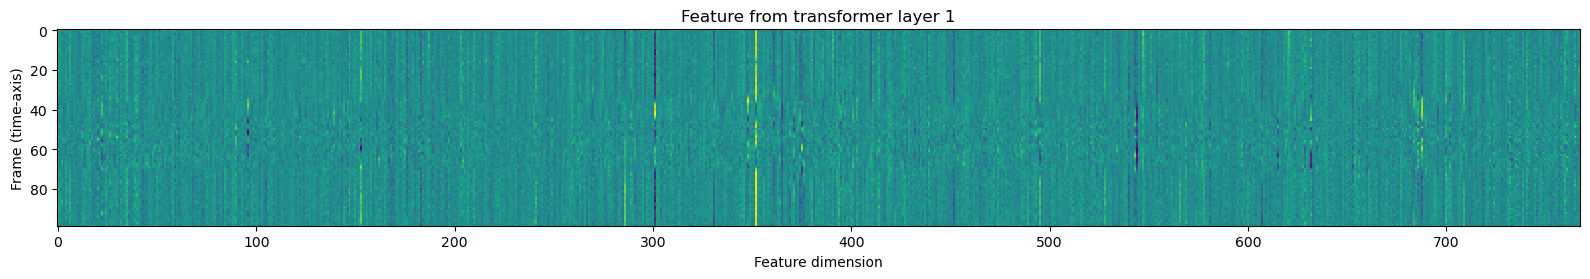

'fig, ax = plt.subplots(len(feats), 1, figsize=(16, 4.3 * len(feats)))\nfor i, feat in enumerate(feats):\n    print(feat.shape)\n    ax[i].imshow(feat[0].cpu(), interpolation="nearest")\n    ax[i].set_title(f"Feature from transformer layer {i+1}")\n    ax[i].set_xlabel("Feature dimension")\n    ax[i].set_ylabel("Frame (time-axis)")\nplt.tight_layout()\nplt.show()'

In [4]:
target_custom_keyword = "computer"
speech_file = '/Users/nasim/Documents/MLEng_bootcampt/Spotify/code/Precise-Community-Data/heycomputer/en/heycomputer-en-2aa5faeb-52b7-496d-a84a-c8504a2a1d74.wav' 
IPython.display.Audio(speech_file)

#========================================================
print('==================================================================')
asr = wav2vec2Model()

fs_model , model_labels = asr.get_model_detail()
print("model sampling freq = ",fs_model)
print("model labels = ", model_labels)

model      = asr.get_asr_model(device)
wav, fs    = asr.load_singlefile(speech_file)
wav        = asr.resample(wav,fs)
feats      = asr.get_layer_features(wav)
trasncript = asr.feat_classification(wav)
print("outcome pf ASR model is: ", trasncript)


# Delete the file
#os.remove(wav)

#========================================================
print('==================================================================')
common_words = ['hi', 'bye', 'yes', 'see']

kws, kws_flag = analyze_asr_transcript (trasncript, target_custom_keyword)
if kws_flag:
    
    print("Keyword detected correctly: ", kws)
    score_num, score_val = analyze_uniqueness_ask (kws[1],common_words)
    print("Uniquness score of custom Keyword is : ", score_num, ', it means: ', score_val)
else:
    if kws == "":
        print("No keyword detected!")
    else:
        print("A wrong keyword detected:",kws)
print('==================================================================')
    
#========================================================
# Feature analysis
feats = np.asarray(feats)



# plot features of first layer in transformer:
i = 0
feat = feats[i]
print(feat.shape)
fig, ax = plt.subplots(1, 1, figsize=(16, 4.3 * len(feat)))
ax.imshow(feat[0].cpu(), interpolation="nearest")
ax.set_title(f"Feature from transformer layer {i+1}")
ax.set_xlabel("Feature dimension")
ax.set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

"""fig, ax = plt.subplots(len(feats), 1, figsize=(16, 4.3 * len(feats)))
for i, feat in enumerate(feats):
    print(feat.shape)
    ax[i].imshow(feat[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()"""




In [5]:
### zero shot learning




### To test the wav2vec on clean (no noise) Google command v2 dataset:

In [6]:
### Load google command  v2

from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
validation_set = SubsetSC("validation")
test_set = SubsetSC("testing")

print("Number of Examples in train set:", len(train_set))
print("Number of Examples in validation set:", len(validation_set))
print("Number of Examples in test set:", len(test_set))

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Number of Examples in train set: 84843
Number of Examples in validation set: 9981
Number of Examples in test set: 11005


In [7]:
labels_test = sorted(list(set(datapoint[2] for datapoint in test_set)))
spk_id_test = sorted(list(set(datapoint[3] for datapoint in test_set)))
print("length of labels in test set is= ", len(labels_test))
print("test labels are: ", labels_test)

length of labels in test set is=  35
test labels are:  ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [61]:

"""class ANALYZE_PRED:
    def __init__(self):
        #self.wrong_dict = {}
        #self.correct_dict = {}
        self.fs = 16000
        
    
    def add_for_eval_wrongPredict (self,wav, file_n):
    
    
    
    def add_for_eval_correctPredict (self,wav , file_n):"""


def number_of_correct(pred, target):
    # count number of correct predictions
    pred = pred.lower()
    pred = pred.split('|')
    if pred[0] == target:
        cnt = 1
    else:
        cnt = 0
        
    return cnt
def pause():
    programPause = input("Press the <ENTER> key to continue...")

def test(test_set):
    cnt = 0
    correct = 0
    wrong_predIdx_lst = []
    for i in range(0,len(test_set),50):
        wav, fs, target, _, _ = test_set[i]
        wav = asr.resample(wav,fs)
        
        pred = asr.feat_classification(wav)
        #print("iteration ", i+1, "- and pred is : ", pred," and target: ",  target)
        if number_of_correct(pred, target):
            correct += 1
        else:
            wrong_predIdx_lst.append(i)
            print(f"Data point #{i}. Expected: {target}. Predicted: {pred}.")
            #pause()
        
        cnt+=1
        #if i>100:
        #    break
    return correct, cnt, wrong_predIdx_lst



In [62]:
#anz = ANALYZE_PRED()
print(len(test_set))
correct, i_test, wrong_predIdx_lst = test(test_set)
print(i_test)
print(correct)
print("predcitions accuracy is : ", 100*correct/(i_test), "%" )

11005
Data point #0. Expected: right. Predicted: WRIGHT|.
Data point #200. Expected: right. Predicted: GRIN.
Data point #300. Expected: right. Predicted: LIGHT|.
Data point #350. Expected: right. Predicted: BRY|.
Data point #450. Expected: eight. Predicted: IT|.
Data point #600. Expected: eight. Predicted: HATE|.
Data point #650. Expected: eight. Predicted: E|.
Data point #700. Expected: eight. Predicted: EATE|.
Data point #750. Expected: eight. Predicted: |.
Data point #800. Expected: eight. Predicted: .
Data point #950. Expected: cat. Predicted: CAP|.
Data point #1250. Expected: backward. Predicted: BACUA|.
Data point #1400. Expected: learn. Predicted: L.
Data point #1450. Expected: learn. Predicted: THEN|.
Data point #1500. Expected: learn. Predicted: LATC|.
Data point #1550. Expected: bed. Predicted: MAT|.
Data point #1650. Expected: bed. Predicted: BAD|.
Data point #1700. Expected: bed. Predicted: BAD.
Data point #1750. Expected: happy. Predicted: HEAVEN|.
Data point #2000. Expect

### Listening Assessment for Wrong Predictions

In [39]:

for i in range(len(wrong_predIdx_lst)):
    
    wav, fs, target, _, _ = test_set[wrong_predIdx_lst[i]]
    wav = asr.resample(wav,fs)
    ipd.display(ipd.Audio(wav.numpy(), rate=fs))

## Few shot leanring for KWS (FSL-KWS)
### Expectation: reach accuracy of above 90% on "Google Speech Command v2" via FSL-KWS

ref:
 - https://github.com/roman-vygon/triplet_loss_kws
 - https://github.com/ArchitParnami/Few-Shot-KWS
 - https://github.com/harvard-edge/multilingual_kws


In [57]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="FSL-KWS-1.png", width=700, height=700)


In [58]:
Image(url="FSL-KWS-2.png", width=500, height=500)

### Try a model fine-tuned for KWS: superb/wav2vec2-base-superb-ks 

In [85]:
# superb/wav2vec2-base-superb-ks 
# https://huggingface.co/superb/wav2vec2-base-superb-ks

import torch
from datasets import load_dataset
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
from torchaudio.sox_effects import apply_effects_file

effects = [["channels", "1"], ["rate", "16000"], ["gain", "-3.0"]]
def map_to_array(example):
    speech, _ = apply_effects_file(example["file"], effects)
    example["speech"] = speech.squeeze(0).numpy()
    return example

# load a demo dataset and read audio files
dataset = load_dataset("anton-l/superb_demo", "ks", split="test")
dataset = dataset.map(map_to_array)

model = Wav2Vec2ForSequenceClassification.from_pretrained("superb/wav2vec2-base-superb-ks")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-ks")



Found cached dataset superb_demo (/Users/nasim/.cache/huggingface/datasets/anton-l___superb_demo/ks/1.9.0/77d23894ff429329a7fe80f9007cabb0deec321316f8dda1a1e9d10ffa089d08)
Loading cached processed dataset at /Users/nasim/.cache/huggingface/datasets/anton-l___superb_demo/ks/1.9.0/77d23894ff429329a7fe80f9007cabb0deec321316f8dda1a1e9d10ffa089d08/cache-7bcad46e43276848.arrow


In [86]:
# compute attention masks and normalize the waveform if needed
inputs = feature_extractor(dataset["speech"], sampling_rate=16000, padding=True, return_tensors="pt")
logits = model(**inputs).logits
predicted_ids = torch.argmax(logits, dim=-1)
target_ids = dataset["label"]

print(predicted_ids)
print(target_ids)


tensor([11, 10, 10, 10,  3,  9,  8,  1])
[10, 11, 11, 11, 3, 9, 4, 1]


In [87]:
def get_id2label_target (idx):
    classes_dict1 = {0:"yes",1:"no",2:"up",3:"down",4:"left",5:"right",6:"on",7:"off",8:"stop",9:"go",10:"_silence_", 11:"_unknown_"}
    return classes_dict1[idx]

def get_id2label_pred (idx):
    classes_dict2 = {0:"yes",1:"no",2:"up",3:"down",4:"left",5:"right",6:"on",7:"off",8:"stop",9:"go",11:"_silence_", 10:"_unknown_"}
    return classes_dict2[idx]


pred_labels = [get_id2label_pred(_id) for _id in predicted_ids.tolist()]
target_labels = [get_id2label_target(_id) for _id in target_ids]
print("pred_labels: ",pred_labels)
print("Target labels: ", target_labels)
#print(dataset)
#print("- All labels in dataset: ", dataset.features['label'])



pred_labels:  ['_silence_', '_unknown_', '_unknown_', '_unknown_', 'down', 'go', 'stop', 'no']
Target labels:  ['_silence_', '_unknown_', '_unknown_', '_unknown_', 'down', 'go', 'left', 'no']
